<h1> <center>Пример подсчета когерентности тематической модели средствами библиотеки BigARTM </center></h1>

### Что такое когерентность тематической модели

Одним из самых главных требований, выдвигаемых к тематической модели, является требование *человеческой интерпретируемости*. Как было показано в ряде статей, *человеческая интерпретируемость* хорошо скоррелированна с такой мерой качества тематической модели, как когерентность. Приведем формулу для расчета когерентности одной скрытой темы $t$ тематической модели:
$$ PMI_t = \frac{2}{k(k-1)}\sum_{i=1}^{k-1}\sum_{j=i}^kvalue(w_i,w_j)$$

Здесь $value(w_i,w_j)$ - это оценка, основанная на совстречаемости слов, посчитанная по некоторому корпусу текстов.
Например:
- positive PMI: $$pPMI=\left[\log\frac{n(u,v)n}{n(u)n(v)}\right]_{+},$$
- сглаженный логарифм условной вероятности:
$$score=\log\frac{n(u,v)+1}{n(v)}$$

Здесь $n(u,v)$ - число окон определенной длины (обычно длины 10), в которых одновременно встречаются слова $v$ и $u$, $n(u)$ и $n(v)$ - это число окон, в которых вообще встречаются слова $u$ и $v$ соответственно. $n$ - это общее число окон, которое было просмотрено.

### Необходимые данные для проведения эксперимента  

- Коллекция текстовых документов, в любом удобном для Вас формате
- [UCI](http://bigartm.readthedocs.io/en/stable/formats.html) словарь коллекции, по которой обсчитывалась статистика совстречаемости. Фактически это файл, в котором в каждой новой строке записан елемент словаря (слово)
- Словарь с данными о совстречаемости слов. Строчка в словаре совстречаемости слов выглядит так:
$$word_{id}\text{ }word_{id}\text{ }value$$
Здесь $word_{id}$ - это ID слова в UCI словаре, по которой считалась статистика, если считать, что индексация словаря ведется с 0, $value$ - оценка совстрецаемости слов, например $pPMI.$  
**Обратите внимание, что обычно предполагается, что индексация словаря в UCI формате ведется с 1. Но в BigARTM на данный момент реализованые функции предполагают именно такой формат (индексация с 0).**

Демонстрацию будем производить на основе коллекции [Постнауки](www.postnauka.ru).  
Наша коллекция уже приведена к формату [UCI](http://bigartm.readthedocs.io/en/stable/formats.html). Разумеется, Ваша коллекция может быть в любом из удобных для Вас формате.  
Статистику совстречаемости слов мы считали также по коллекции Постнауки.

## Пример обучения модели

Импортируем библиотеки

In [4]:
%matplotlib inline
import glob
import os
import sys
import codecs
import json
import artm
import numpy as np

print u"ARTM version: {}".format(artm.version())

import matplotlib.pyplot as plt

ARTM version: 0.8.1


Конвертируем коллекцию Постнауки в UCI формате во внутренний формат BigARTM (батчи)

In [5]:
data_path_UCI = 'postnauka/UCI'
data_path_batches = 'postnauka/batches/'
if len(glob.glob(data_path_batches + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(collection_name='pn', data_format='bow_uci', \
                data_path = data_path_UCI, batch_size = 500, target_folder=data_path_batches)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=data_path_batches, data_format='batches')

Для того, чтобы передать информацию о совстречаемости слов, нужно сконвертировать имеющиеся у нас данные в удобный для BigARTM формат - словарь Dictionary.

In [6]:
cooc_dict = artm.Dictionary()

Воспользуемся функцией `gather(...)`. ЕЕ параметры:
- `data_path` - путь до обрабатываемой коллекции в формате батчей
- `cooc_file_path` - путь до файла с информацией о совстречаемости слов (считая, что индексация идет с 0)
- `vocab_file_path` - путь до UCI словаря коллекции, по которой считалась статистика совстречаемости
- `symmetric_cooc_values` - булева переменная, `True`, если в файле совстречаемости не содержится информация о порядке слов в паре

In [7]:
cooc_dict.gather(
    data_path='postnauka/batches/',
    cooc_file_path = "postnauka/ppmi_postnauka.txt",
    vocab_file_path='postnauka/UCI/vocab.pn.txt',
    symmetric_cooc_values=True)

### Строим модель

Возьмем для упрощения только одну модальность ngramm, имеющуюся в коллекции

In [8]:
topicNum = 250
class_ids={u'ngramm':1.0}

Регуляризаторы

In [9]:
regularizers_list = []
regularizers_list += [artm.SmoothSparsePhiRegularizer(name='SPPhiNgrammReg', class_ids=[u'ngramm'], tau=0.001)]
regularizers_list += [artm.SmoothSparseThetaRegularizer(name='SmoothThetaReg', tau=0.001)]

Создадим метрики, которые хотим снимать с модели

In [10]:
scores_list = []
scores_list += [artm.SparsityPhiScore(name='SparsityScoreNgramm', class_id='ngramm')]
scores_list += [artm.SparsityThetaScore(name='SparsityScoreTheta')]
scores_list += [artm.PerplexityScore(name='PerplexityScore')]

Когерентность считается на основе списка топ слов, длины k. Создадим соответствующие метрики для $k=10$ и $k=50$

In [11]:
scores_list += [artm.TopTokensScore(name='TopTokensScoreNgramm10',
                                    class_id='ngramm', 
                                    num_tokens=10, 
                                    dictionary=cooc_dict)]
scores_list += [artm.TopTokensScore(name='TopTokensScoreNgramm50',
                                    class_id='ngramm', 
                                    num_tokens=50, 
                                    dictionary=cooc_dict)]

Инициализируем модель

In [12]:
model = artm.ARTM(num_topics=topicNum,
                  dictionary=batch_vectorizer.dictionary,
                  class_ids=class_ids,
                  regularizers=regularizers_list,
                  scores=scores_list,
                  num_document_passes=5)

Теперь запустим 40 проходов коллекции оффлайновым алгоритмом

In [13]:
model.fit_offline(batch_vectorizer,num_collection_passes=40)

Теперь построим графики зависимостей снимаемых с моделей метрик от номера итерации

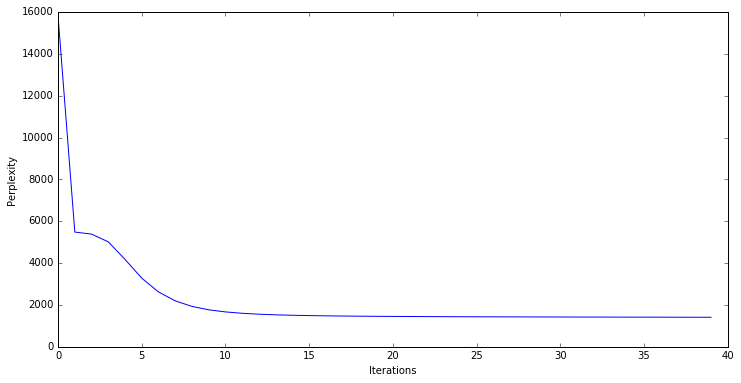

In [19]:
plt.figure(figsize=(12,6),dpi=90)
plt.plot(xrange(model.num_phi_updates),model.score_tracker['PerplexityScore'].value)
plt.xlabel('Iterations')
plt.ylabel('Perplexity')

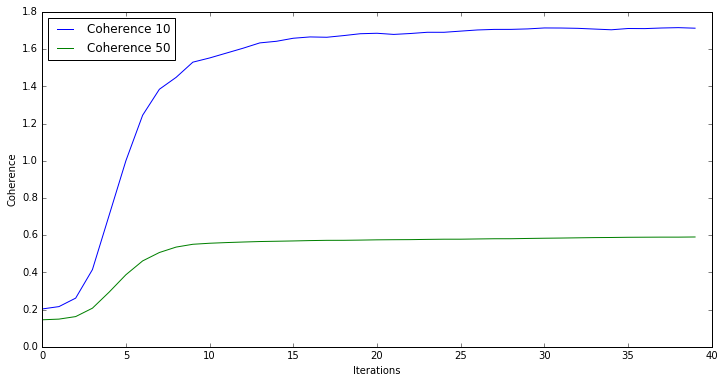

In [22]:
plt.figure(figsize=(12,6),dpi=90)
plt.plot(xrange(model.num_phi_updates),
         model.score_tracker['TopTokensScoreNgramm10'].average_coherence, 
         label="Coherence 10")
plt.plot(xrange(model.num_phi_updates),
         model.score_tracker['TopTokensScoreNgramm50'].average_coherence, 
         label="Coherence 50")
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Coherence')

Также можно распечатать списки топ слов, собираемых метриками `TopTokensScoreNgramm10` и `TopTokensScoreNgramm50`

In [27]:
for topic, words in model.score_tracker['TopTokensScoreNgramm10'].last_tokens.iteritems():
    print topic
    for word in words:
        print word,
    print 

topic_235
матрица струна точка число параметр пространство созвездие возникать частота являться
topic_248
япония японец страна японский запад европеец западный восток китай отношение
topic_197
изучение палеоботаник работа исследование растение являться современный изучаться усталость проблема
topic_175
аргумент моральный являться общий свобода личность согласие вопрос свободный благо
topic_195
насекомое растение муравей вид пестицид дерево муравьев яд вредитель гриб
topic_194
музей музейный экспозиция место коллекция современный естественно посетитель предмет стать
topic_193
внимание плод случай птица сторона поскольку гибель феномен экосистема происходить
topic_192
клетка ткань стволовой_клетка организм использовать существовать белка взять клеточный получить
topic_191
театр роль пьеса герой актёр театральный костюм сцена зритель играть
topic_174
культура культурный принцип лосев традиция форма представитель особенность образ смысл
topic_214
фильм испытуемый вербальный зритель евгений